In [1]:
# need to install below to enable some features in plot_partial_dependence
%pip install scikit-learn==0.24

### Set up

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter


In [2]:
# ==================== Define functions ====================

def MyRsq(predict, actual): # Function to calculate R-squared
    dif = predict - actual
    dif = dif ** 2
    mse = np.mean(dif)
    rsq = 1 - mse / np.var(actual)
    return rsq

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result





In [3]:
# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')





[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators


In [4]:
AllData.head()

,x,y,Bio_01,Bio_02,Bio_03,Bio_04,Bio_05,Bio_06,Bio_07,Bio_08,...,Bio_18,Bio_19,DG_000_014bt_dens,Elv,Pigs,Rice,UR,VD,Adjusted_Pop_Count_2015,FOI
0,13717.407892,5959.817018,-3.533434,14.667511,24.080265,1743.920532,25.633081,-35.277302,60.910385,16.902985,...,280.531250,15.885687,0.096940,324.425049,0.086128,8.804602,1,0.285594,27.158179,0.163308
1,13722.407892,5959.817018,-3.515078,14.740572,24.211077,1737.165649,25.591284,-35.291855,60.883141,16.848240,...,281.375214,16.805054,0.106271,339.754822,0.088851,0.000000,1,0.282270,46.891705,0.164386
2,13727.407892,5959.817018,-3.505363,14.655778,24.143412,1735.075928,25.490971,-35.211075,60.702045,16.827511,...,281.311707,16.730371,0.110514,328.791656,0.055739,0.000000,1,0.296362,29.772409,0.165014
3,13747.407892,5959.817018,-3.203640,14.476027,23.880190,1734.776611,25.709829,-34.909279,60.619106,17.131897,...,281.548340,16.541552,2.518467,281.210266,0.125748,5.982415,1,0.187785,10.536764,0.163172
4,13757.407892,5959.817018,-3.142176,15.133987,24.704348,1729.607788,26.100000,-35.160149,61.260151,17.148170,...,282.543854,16.618938,2.763509,273.763184,0.072534,0.000000,1,0.313313,13.470044,0.163207


In [5]:
# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')





[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index


In [6]:
# ==================== Create Train-Validate-Test dataset ====================
# ==================== SJ: Thinning the dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Train_Non_NA = Train_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Validate_Non_NA = Validate_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# SJ: Thinning: take 10%
Test_Non_NA = Test_Non_NA.sample(frac = 0.1, replace = False, random_state = 1)

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA
# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)

# ----- Find max_ft for randomforest regression = numft / 3 (default) -----
num_ft = np.floor(X_train.shape[1]/3)
if (num_ft != X_train.shape[1]/3):
    num_ft = num_ft + 1
num_ft = int(num_ft)


[Preprocessing] Total Training containing NA: 0 / 488914 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 89152 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 123240 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


## Gradient Boosting

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

#### Model building

In [9]:
# ==============Hyperparameter Tuning with GBoosting

# Random Search
# tune colsample_bytree,n_estimators,max_depth, lambda
# There is a relationship between the number of trees (n_estimators) and the depth of each tree (max_depth)
# Create the parameter grid: gbm_param_grid
# didn't tune alpha as I tuned lambda

gbr_param_grid = {
    'learning_rate': [0.0001,0.001, 0.01, 0.05,0.1,0.15,0.3],
    'n_estimators': range(50,250,10),
    'max_depth': [4,6,8,10],
    'min_samples_leaf': [5,10,15], 
    'subsample': np.arange(3,8)/10,
    'max_features':['auto','sqrt','log2']
}
# Instantiate the regressor: gbm
gbr = GradientBoostingRegressor()
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=gbr_param_grid, 
                                    estimator=gbr, 
                                    scoring="neg_mean_squared_error",  
                                    cv=4, #kfolds
                                    verbose=1,
                                   n_jobs = -1)
# Fit randomized_mse to the data
randomized_mse.fit(X_train, Y_train) #actually, should just use X_train as the combined train and test, as CV will have its own split

# Print the best parameters
# print("Best parameters found: ", randomized_mse.best_params_)

bestp = randomized_mse.best_params_
bestp

{'subsample': 0.7,
 'n_estimators': 220,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 10,
 'learning_rate': 0.1}

In [8]:
# for reference
bestp = {'subsample': 0.7,
 'n_estimators': 220,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 10,
 'learning_rate': 0.1}

Use the best params to:

- redo the fitting process, 
- predict on test, 
- calculate test MSE, 
- get CI,
- plot the feature importance

In [9]:
# ============== Refit GBoost with the optimal params

gbr = GradientBoostingRegressor(n_estimators = bestp['n_estimators'],
                          max_depth = bestp['max_depth'],
                                learning_rate = bestp['learning_rate'],
                                subsample = bestp['subsample'],
                                min_samples_leaf = bestp['min_samples_leaf'],
                                random_state = 123)
gbr.fit(X_train, Y_train)
yhat = gbr.predict(X_test)

In [10]:
# ============== Save the model
filename_model = Savepath + 'ModelGB_' + '.model'
print('[Saving] Save training model')
pickle.dump(gbr, open(filename_model, 'wb'))

[Saving] Save training model


In [13]:
# You can load the model by the following way

# filename_model = Savepath + 'ModelGB_' + '.model'
# gbr = pickle.load(open(filename_model, 'rb'))

#### Evaluate model performance

In [11]:
# ============== 1. MSE
rmse = np.sqrt(mean_squared_error(Y_test, yhat))
mse = mean_squared_error(Y_test, yhat)
print("test RMSE: %f" % (rmse))
print("test MSE: %f" % (mse))

test RMSE: 0.035953
test MSE: 0.001293


The MSE is relatively low compared to RF. However, it is slightly higher than XGBoost. 

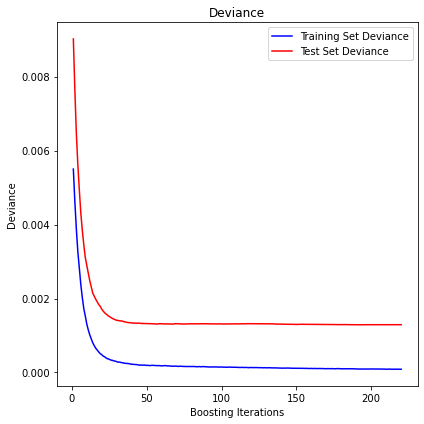

In [12]:
# ============== 2. Deviance (train/test error)

test_score = np.zeros((bestp['n_estimators'],), dtype=np.float64)
for i, yhat in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(yhat,Y_test)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(bestp['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(bestp['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

The i-th train_score is the deviance (= loss) of the model at iteration i on the in-bag sample. Calculation of deviance is dependent on the loss function chosen. In this case, the default is 'ls', i.e. least-square error. 

Testing set deviance decreases as iterations increases, but tends to remain stable after 25 iterations, suggesting that the model is preventing overfitting. This is mainly due to the shrinkage parameter. 

#### Model output

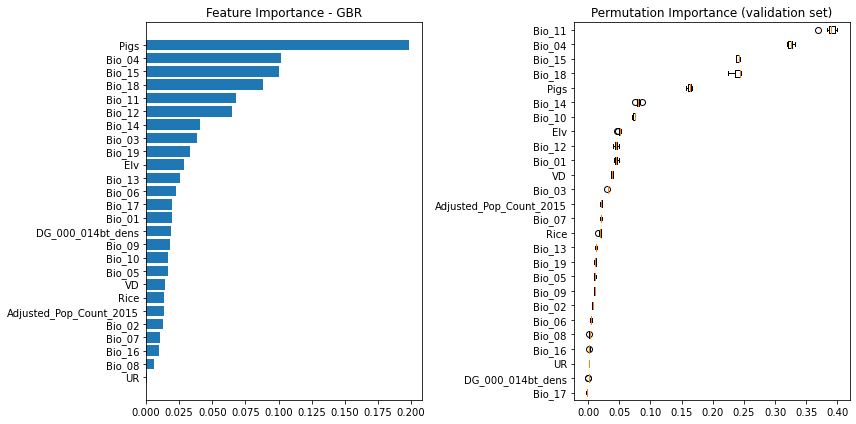

In [13]:
# ============== 1. get feature importances
# it is the same API interface like for ‘scikit-learn’ models

# feature importance
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance - GBR')

# permutation importance 
result = permutation_importance(gbr, X_test, Y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (Test set)")

figname2 = Savepath + 'GBR_permu_feature_imp.png'
plt.savefig(figname2)

fig.tight_layout()
plt.show()


In [14]:
# list of top 10 features based on permutation importance

top10 = np.flip(np.array(X_train.columns)[sorted_idx])[:10]
top10

array(['Bio_11', 'Bio_04', 'Bio_15', 'Bio_18', 'Pigs', 'Bio_14', 'Bio_10',
       'Elv', 'Bio_12', 'Bio_01'], dtype=object)

MDI(mean decrease in impurity)-based feature importance and permutation importance tend to give slightly different results. This is due to the different measurement philosophy. 

The **permutation importance** is often more robust against the cardinality of variables. Based on the scikit-learn literature: impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories (https://scikit-learn.org/stable/modules/permutation_importance.html).

In this example, both importance scores are more or less consistent with each other. 

Note, that in our previous analysis using PCA, we have identified a number of features that are closely related. When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important(https://scikit-learn.org/stable/modules/permutation_importance.html). Therefore we may want to cluster **correlated** features BEFORE running the gradient boosting and calculating permutation importance.

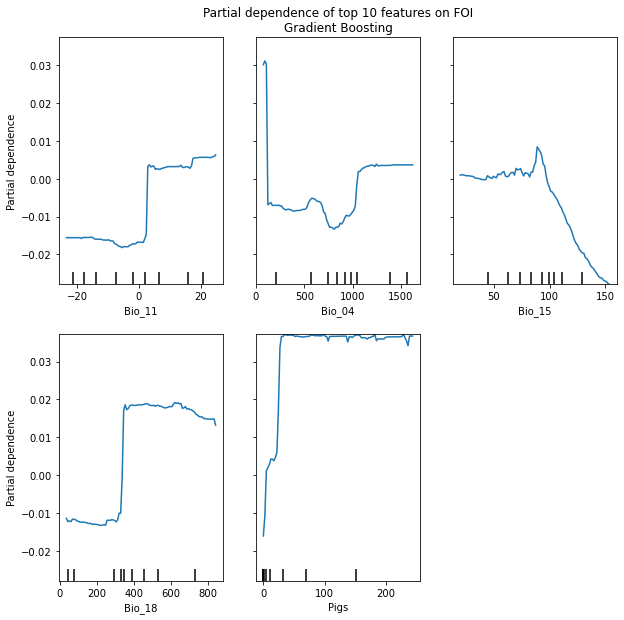

In [15]:
# ============== 2. get dependence plots
# Partial dependence plots
_, ax = plt.subplots(figsize=(10, 10))
ax.set_title( 'Partial dependence of top 5 features on FOI\nGradient Boosting')
display2 = plot_partial_dependence(gbr,X_test, top10[:5],ax = ax)

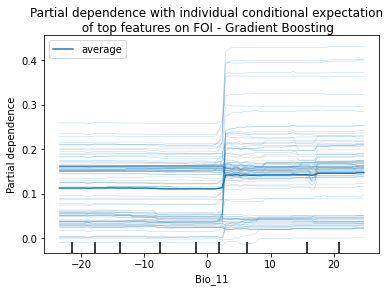

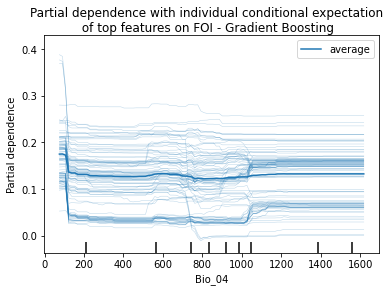

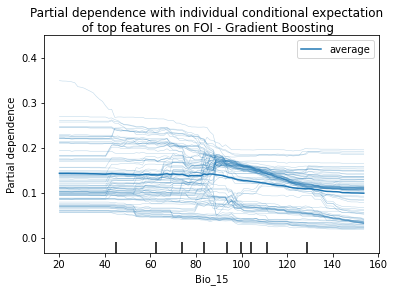

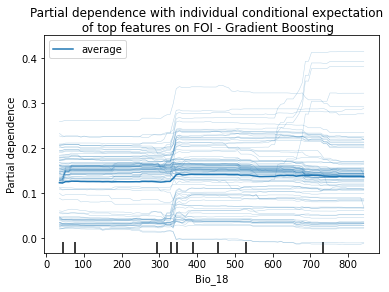

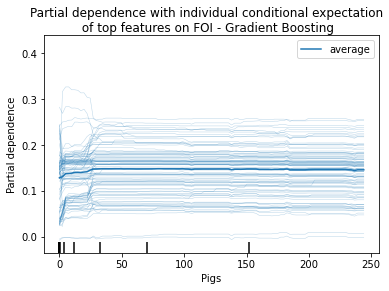

In [16]:
# Both PD and ICE (individual conditional expectation) plots
# limit to 100 ICE curves to avoid overcrowding
for i in range(5):
    display3 = plot_partial_dependence(gbr,X_test, [top10[i]], kind = 'both', subsample = 100)
    display3.figure_.suptitle(
        'Partial dependence with individual conditional expectation\n of top features on FOI - Gradient Boosting'
    )
    display3.figure_.subplots_adjust(wspace=0.2, hspace=1)


Here we look at the partial dependency plots and the individual conditional expectation plots. 

#### PDP
The above one-way PDP specifies the relationship between target variable (FOI) and the top 10 input feature, based on the permutation importance score. The line indicates the **average** effect of the input feature.
The y axis of PDP represents the **marginal** impact of the independent variable to the dependent variable. 

- We can see that the marginal effects of each variable on the FOI are non-linear. For Bio_11 and Bio_18, they appear to be stepwise. 

Note that a major assumption of the PDP is that the features are **independent**. When there are interactions between feature, PDP tend to obscure the heterogeneous relationship created by interactions. Hence we check ICE for more insights. We should also check PDP against the feature importance to check if some variables need to interact with others to show an effect. See this [article](https://towardsdatascience.com/random-forest-3a55c3aca46d) for an example. 


#### ICE
An ICE plot visualizes the dependence of the prediction on a feature for each sample separately with **one line per sample**. Each line represents a sample, describing the effect of that feature on FOI, given all other features remain constant. An ICE plot can highlight the variation in the fitted values across the range of a feature. This suggests where and to what extent heterogeneities might exist.

The y axis of ICE represents the **expected** value of the dependent variable. 

- Comparing the ICE plots with PDP, individual contributions of each X variable vary by sample. For example, Bio_18 values in certain ranges increase the FOI sharply, while the average effect remains rather constant.

Note that with highly correlated features, ICE plots may produce invalid data points as well. 

#### More references

- Goldstein, Alex, Adam Kapelner, Justin Bleich, and Emil Pitkin. 2013. “Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation.” Journal of Computational and Graphical Statistics 24 (September). doi:10.1080/10618600.2014.907095.

- Hastie, T., R. Tibshirani, and J. Friedman. 2013. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer New York. https://books.google.de/books?id=yPfZBwAAQBAJ.

- Molnar, Christoph. 2019. Interpretable Machine Learning: A Guide for Making Black Box Models Explainable.



#### Model prediction

In [17]:
# ============== Prediction intervals
# This is again using quantile regression 

# confidence level
alpha = 0.95
# quantile regression 
clf = GradientBoostingRegressor(loss = 'quantile',alpha = alpha,
    n_estimators = bestp['n_estimators'],
                          max_depth = bestp['max_depth'],
                                learning_rate = bestp['learning_rate'],
                                subsample = bestp['subsample'],
                                min_samples_leaf = bestp['min_samples_leaf'],
                                random_state = 123)
# upper
clf.fit(X_train, Y_train)
y_upper_gbm = clf.predict(X_test)

# lower
clf.set_params(alpha = 1.0 - alpha)
clf.fit(X_train, Y_train)
y_lower_gbm = clf.predict(X_test)

# yhat
clf.set_params(loss='ls')
clf.fit(X_train, Y_train)
y_pred_gbm = clf.predict(X_test)

In [18]:
# dataframe
dat = np.concatenate((Y_test.reshape(-1,1), 
                      y_pred_gbm.reshape(-1,1), 
                      y_lower_gbm.reshape(-1,1), 
                      y_upper_gbm.reshape(-1,1)), axis = 1)
dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])
dat.head()

,y,yhat,lower,upper
0,0.027360,0.027883,0.024599,0.058910
1,0.240316,0.236271,0.195275,0.248580
2,0.156686,0.154457,0.119790,0.155894
3,0.189376,0.173257,0.141101,0.189887
4,0.229561,0.181146,0.107733,0.235900


In [19]:
# sort the dataframe for plotting
dat2 = dat.sort_values('y')
dat2.head()

,y,yhat,lower,upper
6256,4.301107e-08,-0.002299,-0.004904,0.152106
49,4.321768e-08,-0.001410,0.005221,0.185535
6032,4.325576e-08,0.019520,0.005902,0.145135
4186,4.342776e-08,-0.032377,-0.025040,0.200712
6500,4.366941e-08,-0.014498,-0.000780,0.137577


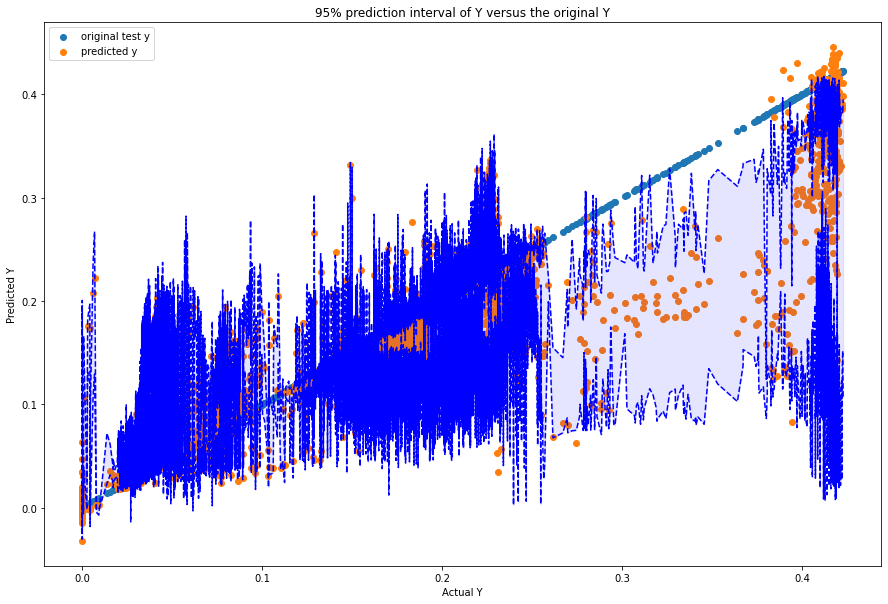

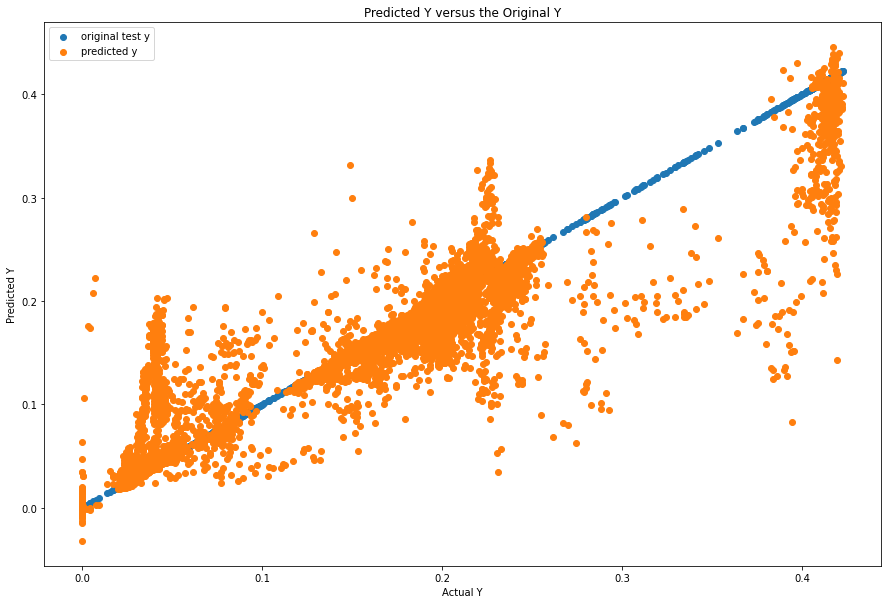

In [20]:
# plot1
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('95% prediction interval of Y versus the original Y')
plt.legend()

# plot2
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(dat2['y'], dat2['y'],label = 'original test y')
plt.scatter(dat2['y'], dat2['yhat'],label = 'predicted y')
# ax.plot(dat2['y'], dat2['upper'], '--', color = 'b')
# ax.plot(dat2['y'], dat2['lower'], '--', color = 'b')
# ax.fill_between(dat2['y'], dat2['lower'],dat2['upper'], color = 'blue',alpha = .1)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('Predicted Y versus the Original Y')
plt.legend()

The above plots show that: 

- The quantile regression is not really capturing the true Y as Y goes beyond 0.25.

- The quantile regression is capturing the true Y for Y < 0.25. 

- GBM tends to under-estimat the actual Y if Y > 0.25. 

What characteristics do the points with Y > 0.25 have? 

1. Check distribution of Y_test
2. Check the X_validate attributes for Y_test > .25

In [21]:
print(f'The proportion of Y_test > 0.25 out of the whole validation sample is: ',sum(Y_validate > .25)/len(Y_validate))


The proportion of Y_test > 0.25 out of the whole validation sample is:  0.07021873247335951


(0.0, 1270.0)

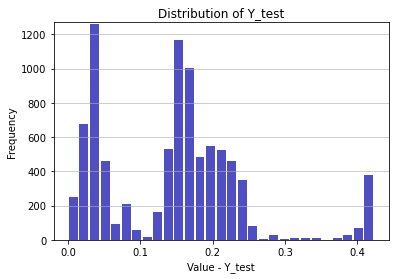

In [22]:
# check distribution of Y_test
n, bins, patches = plt.hist(x=Y_test, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value - Y_test')
plt.ylabel('Frequency')
plt.title('Distribution of Y_test')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [23]:
# summary of the top 10 features in X_test
X_test[top10].describe()

,Bio_11,Bio_04,Bio_15,Bio_18,Pigs,Bio_14,Bio_10,Elv,Bio_12,Bio_01
count,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000,8915.000000
mean,-1.750770,913.612278,88.863124,371.347749,48.255849,24.665881,20.702092,1235.634715,936.290987,9.990801
std,15.514061,440.995848,34.101633,259.098251,111.728052,53.157532,8.327236,1711.512668,872.378838,11.215092
min,-32.980190,18.445360,8.366812,12.000000,0.000000,0.000000,-8.891908,-1.856663,21.637270,-21.228050
25%,-15.315722,619.814606,68.455242,169.964134,0.006145,2.000000,17.047182,142.719353,472.342163,0.702137
50%,-1.804798,919.155029,93.614212,347.683411,4.051399,5.000000,21.794037,447.965118,620.516785,10.112035
75%,7.685284,1238.111816,107.144302,491.099243,50.518255,14.122475,26.636167,1264.423828,1270.198120,17.827042
max,27.151747,1816.864014,171.633545,1863.851318,4356.160156,273.112274,36.390942,6555.198242,4580.530762,28.476038


In [25]:
# summary of the top 10 features in X_test, for Y_test > 0.25
Test_Non_NA[Test_Non_NA.FOI > 0.25][top10].describe()

,Bio_11,Bio_04,Bio_15,Bio_18,Pigs,Bio_14,Bio_10,Elv,Bio_12,Bio_01
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000
mean,20.375625,155.466838,25.184457,726.044689,23.995489,177.562777,24.122973,677.215284,2916.963887,22.408973
std,7.086740,234.442573,23.699777,169.435341,82.526586,85.221314,5.298499,916.123056,780.333447,5.570807
min,0.208959,18.445360,8.366812,194.001221,0.000000,1.000000,4.682341,1.483147,786.599915,3.295267
25%,16.666700,42.765381,10.927839,646.603790,0.004880,158.766697,24.069780,62.737976,2801.886230,18.365975
50%,23.896437,66.492470,13.022167,770.561432,0.011963,218.322174,26.478497,286.966446,3184.587646,25.038200
75%,25.596200,101.344673,25.813122,838.559082,0.111905,234.332638,27.229648,803.933914,3421.610535,26.516056
max,27.151747,895.782227,95.472511,1036.625244,1026.933838,273.112274,29.012089,4118.656250,4211.121094,27.518005


The above suggested that: 

- Y_test only takes a very small proportion (7%) of the total validation dataset. Therefore failing to cover the true Y in the 95% prediction interval is not impacting the overall model performance much. 
- The under-estimation of FOI in the validation set for this range is not captured by the usual model evaluation methods, such as test MSE, plot of train-test error, etc.  
- By reviewing the attributes whose target FOI > 0.25, we see that:

1). Bio_11 is much larger than the whole validation set

2). Bio_04 is much smaller than the whole validation set

3). Other top 10 features can be compared in the similar manner.

- For inference, we should be careful using GBM for records whose X variables fall within the range above. 